In [1]:
! python --version

Python 3.11.9


In [105]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib import patches

import seaborn as sns

import scipy.sparse
from scipy.stats import pearsonr, spearmanr, kendalltau

import geopandas as gpd

import scanpy as sc

import anndata as an
import scanorama

from pathlib import Path

import squidpy as sq

import os
import warnings

from shapely.geometry import Polygon, MultiPolygon, Point
from shapely.affinity import affine_transform

import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from shapely import wkt

from shapely.errors import GEOSException

from shapely.geometry import Polygon, MultiPolygon

import h5py
sc.logging.print_versions()

-----
anndata     0.10.7
scanpy      1.10.0
-----
PIL                         10.3.0
annoy                       NA
anyio                       NA
asciitree                   NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
brotli                      1.0.9
certifi                     2025.01.31
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dask                        2024.5.0
dask_expr                   1.1.0
dask_image                  2023.08.1
datashader                  0.16.1
datatree                    0.0.14
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
executing                  

### Read in 200 genes from panel 

In [6]:
# Read the list of genes, 200 spike genes subset 
genes_to_include_file =  "subset_spikegenes_list.txt"

with open(genes_to_include_file, "r") as file:
    genes_to_include = [line.strip() for line in file]

### Sample information: 


VGN1e1 = late double ridge, VRT-A2a (P1 WT)

VGN1e9 = late double ridge, VRT-A2b (P1 Pol)

VGN1b6 = lemma primorida, VRT-A2a (P1 WT)

VGN1b8 = lemma primorida, VRT-A2b (P1 Pol)

VGN1a6 = terminal spikelet, VRT-A2a (P1 WT)

VGN1a4 = terminal spikelet, VRT-A2b (P1 Pol)

VGN1c2 = carpel extension round, VRT-A2a (P1 WT)

VGN1c3 = carpel extension round, VRT-A2b (P1 Pol)

In [8]:
# Define the filenames of the saved AnnData objects
adata_filenames = {
    "adata_VGN1a6": "qc/adata_VGN1a6_clean.h5ad",
    "adata_VGN1a4": "qc/adata_VGN1a4_clean.h5ad",
    "adata_VGN1b6": "qc/adata_VGN1b6_clean.h5ad",
    "adata_VGN1b8": "qc/adata_VGN1b8_clean.h5ad",
    "adata_VGN1e1": "qc/adata_VGN1e1_clean.h5ad",
    "adata_VGN1e9": "qc/adata_VGN1e9_clean.h5ad",
    "adata_VGN1c2": "qc/adata_VGN1c2_clean.h5ad",
    "adata_VGN1c3": "qc/adata_VGN1c3_clean.h5ad"
}

# Initialize a dictionary to store the loaded AnnData objects
loaded_adata_objects = {}

# Load each file and store it in the dictionary
for name, filename in adata_filenames.items():
    loaded_adata_objects[name] = sc.read_h5ad(filename)
    print(f"Loaded {name} from {filename}")

# Access the loaded AnnData objects
adata_VGN1a6 = loaded_adata_objects["adata_VGN1a6"]
adata_VGN1a4 = loaded_adata_objects["adata_VGN1a4"]

adata_VGN1b6 = loaded_adata_objects["adata_VGN1b6"]
adata_VGN1b8 = loaded_adata_objects["adata_VGN1b8"]


adata_VGN1e1 = loaded_adata_objects["adata_VGN1e1"]
adata_VGN1e9 = loaded_adata_objects["adata_VGN1e9"]


adata_VGN1c2 = loaded_adata_objects["adata_VGN1c2"]
adata_VGN1c3 = loaded_adata_objects["adata_VGN1c3"]

Loaded adata_VGN1a6 from qc/adata_VGN1a6_clean.h5ad
Loaded adata_VGN1a4 from qc/adata_VGN1a4_clean.h5ad
Loaded adata_VGN1b6 from qc/adata_VGN1b6_clean.h5ad
Loaded adata_VGN1b8 from qc/adata_VGN1b8_clean.h5ad
Loaded adata_VGN1e1 from qc/adata_VGN1e1_clean.h5ad
Loaded adata_VGN1e9 from qc/adata_VGN1e9_clean.h5ad
Loaded adata_VGN1c2 from qc/adata_VGN1c2_clean.h5ad
Loaded adata_VGN1c3 from qc/adata_VGN1c3_clean.h5ad


## The goal of this script is to correlate TPM values from microdissection RNA-seq data to counts in in silico dissections in VizGen data 

I first will visualise each in silico dissection (made in Vizgen MERSCOPE visualizer tool), and extract normalised counts from the areas of these ROIs

then I will correlate the counts per ROI to counts in RNA-seq dataset 

First I will define the functions needed for this: 

In [53]:
def plot_rotated_segmentation_and_roi(
    adata,
    segmentation_path,
    roi_csv_path,
    rotation_angle=20,
    xlim=(3400, 4500),
    ylim=(6200, 8000),
    scale_bar_length=500,
    scale_bar_position=(3700, 6300),
    label_offset=(0,0),
    save_path=None
):
    # Prepare adata.obs and extract cell IDs
    adata.obs.index = [str(i).split("-")[0] for i in adata.obs.index]
    adata_df = adata.obs.reset_index().rename(columns={"index": "cell_id"})
    adata_df['cell_id'] = adata_df['cell_id'].astype(str).str.strip()
    cell_ids = adata_df['cell_id'].tolist()

    # Load segmentation and filter by EntityID
    segmentation_df = gpd.read_parquet(segmentation_path)
    segmentation_df['EntityID'] = segmentation_df['EntityID'].astype(str)
    segmentation_df = segmentation_df[segmentation_df['EntityID'].isin(cell_ids)]

    # Ensure geometries are shapely types and valid
    if segmentation_df['Geometry'].dtype == object and isinstance(segmentation_df['Geometry'].iloc[0], str):
        segmentation_df['Geometry'] = segmentation_df['Geometry'].apply(wkt.loads)

    # Store original geometry if needed
    if 'Original_Geometry' not in segmentation_df.columns:
        segmentation_df['Original_Geometry'] = segmentation_df['Geometry']

    # Get bounding box for centroid-based rotation
    bounds = segmentation_df['Original_Geometry'].bounds
    min_x, max_x = bounds.minx.min(), bounds.maxx.max()
    min_y, max_y = bounds.miny.min(), bounds.maxy.max()
    centroid_x = (min_x + max_x) / 2
    centroid_y = (min_y + max_y) / 2

    # Rotation matrix
    angle_rad = np.radians(rotation_angle)
    cos_theta = np.cos(angle_rad)
    sin_theta = np.sin(angle_rad)
    rotation_matrix = [
        cos_theta, -sin_theta,
        sin_theta, cos_theta,
        centroid_x - cos_theta * centroid_x + sin_theta * centroid_y,
        centroid_y - sin_theta * centroid_x - cos_theta * centroid_y
    ]

    # Safely apply affine transformation
    def safe_affine(geom):
        try:
            return affine_transform(geom, rotation_matrix)
        except GEOSException as e:
            print(f"Error transforming geometry: {e}")
            return None

    segmentation_df['Geometry'] = segmentation_df['Original_Geometry'].apply(safe_affine)
    segmentation_df = segmentation_df.dropna(subset=['Geometry'])

    # Load and transform ROI
    roi_df = pd.read_csv(roi_csv_path)
    roi_df['geometry'] = roi_df['geometry'].apply(wkt.loads)
    roi_df['rotated_geometry'] = roi_df['geometry'].apply(safe_affine)

    # --- Plotting ---
    fig, ax = plt.subplots()
    patches_list = []

    for _, row in segmentation_df.iterrows():
        shape = row['Geometry']
        if isinstance(shape, MultiPolygon):
            for poly in shape.geoms:
                patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor='gray', edgecolor='white', linewidth=0.2)
                patches_list.append(patch)
        elif isinstance(shape, Polygon):
            patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor='gray', edgecolor='white', linewidth=0.2)
            patches_list.append(patch)

    collection = PatchCollection(patches_list, match_original=True)
    ax.add_collection(collection)

    # Plot ROIs
    for _, row in roi_df.iterrows():
        roi_shape = row['rotated_geometry']
        roi_name = row.get('EntityID', 'ROI')
        if isinstance(roi_shape, Polygon):
            roi_patch = patches.Polygon(list(roi_shape.exterior.coords), closed=True, facecolor='none', edgecolor='red', linewidth=1.5)
            ax.add_patch(roi_patch)
            label_point = roi_shape.representative_point()
            ax.text(
                label_point.x + label_offset[0],
                label_point.y + label_offset[1],
                roi_name,
                color='black',
                fontsize=10,
                weight='bold'
            )


    # Plot settings
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect('equal')

    # Add scale bar
    scale_bar_x, scale_bar_y = scale_bar_position
    ax.add_line(Line2D(
        [scale_bar_x, scale_bar_x + scale_bar_length],
        [scale_bar_y, scale_bar_y],
        color="black",
        linewidth=2
    ))
    ax.text(
        scale_bar_x + scale_bar_length / 2,
        scale_bar_y - 20,
        f"{scale_bar_length} µm",
        color="black",
        ha="center",
        va="top",
        fontsize=8
    )
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=700, format='png', transparent=False)
        print(f"Figure saved to: {save_path}")

    plt.show()


In [38]:
def get_cells_in_rois(adata, segmentation_path, roi_csv_path):
    # --- Prep adata index and extract cell IDs ---
    adata.obs.index = [str(index).split('-')[0] for index in adata.obs.index]
    adata_df = adata.obs.reset_index().rename(columns={'index': 'cell_id'})
    adata_df['cell_id'] = adata_df['cell_id'].astype(str).str.strip()
    cell_ids = [cid.strip() for cid in adata_df['cell_id'].tolist()]

    # --- Load and filter segmentation data ---
    segmentation_df = gpd.read_parquet(segmentation_path)
    segmentation_df['EntityID'] = segmentation_df['EntityID'].astype(str)
    filtered_segmentation_df = segmentation_df[segmentation_df['EntityID'].isin(cell_ids)].copy()

    # Ensure geometries are actual Shapely objects
    filtered_segmentation_df['Geometry'] = filtered_segmentation_df['Geometry'].apply(
        lambda g: g if isinstance(g, (Polygon, MultiPolygon)) else wkt.loads(g)
    )

    # --- Load ROI and parse geometry ---
    roi_df = pd.read_csv(roi_csv_path)
    roi_df['geometry'] = roi_df['geometry'].apply(lambda g: wkt.loads(g) if isinstance(g, str) else g)

    # --- Compute intersecting cells per ROI ---
    roi_cell_map = {}
    for _, roi_row in roi_df.iterrows():
        roi_name = roi_row['EntityID']
        roi_geom = roi_row['geometry']
        intersecting_cells = filtered_segmentation_df[
            filtered_segmentation_df['Geometry'].apply(lambda g: g.intersects(roi_geom))
        ]['EntityID'].tolist()
        roi_cell_map[roi_name] = set(intersecting_cells)

    # --- Summary ---
    all_unique_cells = set().union(*roi_cell_map.values())
    print(f"\nTotal unique cells across all ROIs: {len(all_unique_cells)}")
    for roi_name, cell_set in roi_cell_map.items():
        print(f"{roi_name}: {len(cell_set)} unique intersecting cells")

    return roi_cell_map

In [56]:
def export_roi_normalised_counts(adata, roi_cell_map, original_roi_key, roi_name, folder_path):
    if original_roi_key not in roi_cell_map:
        raise ValueError(f"ROI key '{original_roi_key}' not found in roi_cell_map.")

    roi_cells = roi_cell_map[original_roi_key]
    roi_adata = adata[adata.obs_names.isin(roi_cells)].copy()

    # Convert to dense if needed and sum across genes
    expr_matrix = roi_adata.X.toarray() if hasattr(roi_adata.X, "toarray") else roi_adata.X
    gene_sums = np.sum(expr_matrix, axis=0)

    # Construct DataFrame
    roi_expression_df = pd.DataFrame(
        data=[gene_sums],
        columns=roi_adata.var_names
    )
    roi_expression_df.insert(0, 'EntityID', roi_name)

    # Ensure output directory exists
    os.makedirs(folder_path, exist_ok=True)
    output_filename = os.path.join(folder_path, f"{roi_name}_normcounts.csv")

    roi_expression_df.to_csv(output_filename, index=False)
    print(f"Saved normalized counts to {output_filename}")

    return roi_expression_df


### WT Late Double Ridge in silico dissection 

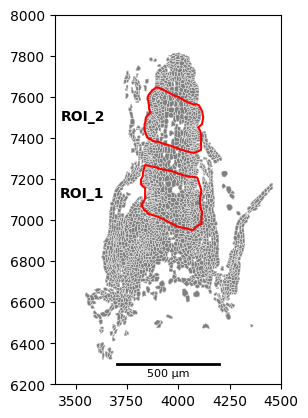

In [54]:
plot_rotated_segmentation_and_roi(
    adata=adata_VGN1e1,
    segmentation_path="cell_segmentation/VGN1e_region1_output/cellpose2_micron_space_VGN1e1.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_1_ROI_geometry.csv',
    rotation_angle=20,
    xlim=(3400, 4500),
    ylim=(6200, 8000),
    scale_bar_length=500,
    scale_bar_position=(3700, 6300),
    label_offset=(-550,0)
)

In [55]:
roi_cell_map = get_cells_in_rois(
    adata=adata_VGN1e1,
    segmentation_path="cell_segmentation/VGN1e_region1_output/cellpose2_micron_space_VGN1e1.parquet",
    roi_csv_path="insilico_dissections/ROI_geometryfiles/Image_1_ROI_geometry.csv"
)


Total unique cells across all ROIs: 637
ROI_1: 353 unique intersecting cells
ROI_2: 284 unique intersecting cells


In [57]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1e1,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_1',
    roi_name='ROI_1B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_1B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_1B,5.347773,2.499181,6.158244,5.523418,7.895158,5.861182,6.524601,13.213298,0.739193,...,37.182705,11.102964,1.542575,119.739098,362.182281,171.498978,81.396629,150.697983,203.614487,350.572388


In [58]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1e1,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_2',
    roi_name='ROI_1C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_1C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_1C,5.81718,1.503505,4.867656,1.534998,5.15928,5.302423,12.542131,11.925657,1.906275,...,19.159676,7.063903,2.169054,47.531612,353.277771,119.968994,74.461731,100.389343,157.012604,296.058014


### P1 Late Double Ridge in silico dissection 

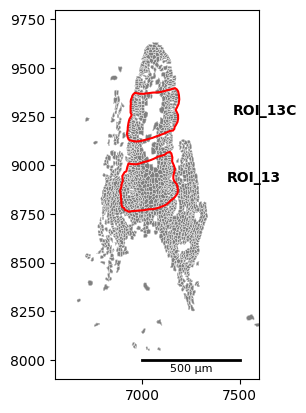

In [65]:
plot_rotated_segmentation_and_roi(
    adata=adata_VGN1e9,
    segmentation_path="cell_segmentation/VGN1e_region9_output/cellpose2_micron_space_VGN1e9.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_10_ROI_geometry.csv',
    rotation_angle=20,
    xlim=(6550, 7600),
    ylim=(7900, 9800),
    scale_bar_length=500,
    scale_bar_position=(7000, 8000),
    label_offset=(400,0)
)


In [66]:
roi_cell_map = get_cells_in_rois(
    adata=adata_VGN1e9,
    segmentation_path="cell_segmentation/VGN1e_region9_output/cellpose2_micron_space_VGN1e9.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_10_ROI_geometry.csv'
)


Total unique cells across all ROIs: 514
ROI_13: 325 unique intersecting cells
ROI_13C: 189 unique intersecting cells


In [67]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1e9,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_13',
    roi_name='ROI_13B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_13B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_13B,5.579095,5.215005,6.489731,5.848384,4.759859,5.281453,5.833492,6.960641,0.420821,...,16.854073,2.909081,0.389465,37.295113,159.825714,95.957672,57.381821,77.789513,94.682899,286.588867


In [68]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1e9,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_13C',
    roi_name='ROI_13C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_13C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_13C,1.663505,0.834798,1.518902,0.66905,2.017133,3.438719,4.420945,3.778885,0.0,...,4.220148,2.544616,1.891108,10.19286,83.708199,32.732227,24.422651,29.383957,52.032795,190.523331


## WT Lemma Primordia in silico dissection 

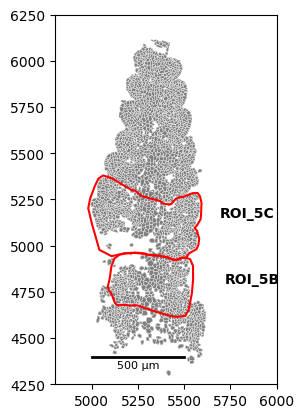

In [70]:
plot_rotated_segmentation_and_roi(
    adata=adata_VGN1b6,
    segmentation_path="cell_segmentation/VGN1b_region6_output/cellpose2_micron_space_VGN1b6.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_4_ROI_geometry.csv',
    rotation_angle=165,
    xlim=(4800, 6000),
    ylim=(4250, 6250),
    scale_bar_length=500,
    scale_bar_position=(5000, 4400),
    label_offset=(400,0)
)


In [71]:
roi_cell_map = get_cells_in_rois(
    adata=adata_VGN1b6,
    segmentation_path="cell_segmentation/VGN1b_region6_output/cellpose2_micron_space_VGN1b6.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_4_ROI_geometry.csv',
)


Total unique cells across all ROIs: 1135
ROI_5B: 438 unique intersecting cells
ROI_5C: 708 unique intersecting cells


In [72]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1b6,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_5B',
    roi_name='ROI_5B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_5B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_5B,15.046754,8.892511,7.769675,7.752186,14.412494,1.946884,20.682058,55.735245,2.868253,...,24.831665,8.836678,4.933178,109.242271,331.058563,215.188522,82.953995,166.281601,257.995544,519.930115


In [73]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1b6,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_5C',
    roi_name='ROI_5C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_5C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_5C,17.367407,22.539911,14.531885,9.090454,12.984058,39.96611,31.063925,81.154411,22.575994,...,46.035698,9.087837,4.197063,305.98645,688.819336,260.828644,175.669296,332.915344,419.301727,513.399719


## Pol Lemma Primordia in silico dissection 

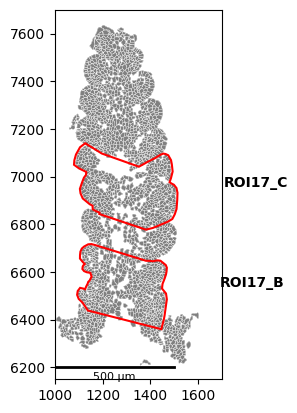

In [76]:
plot_rotated_segmentation_and_roi(
    adata=adata_VGN1b8,
    segmentation_path="cell_segmentation/VGN1b_region8_output/cellpose2_micron_space_VGN1b8.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image15_ROI_geometry.csv',
    rotation_angle=155,
    xlim=(1000, 1700),
    ylim=(6150, 7700),
    scale_bar_length=500,
    scale_bar_position=(1000, 6200),
    label_offset=(400,0)
)


In [77]:
roi_cell_map = get_cells_in_rois(
    adata=adata_VGN1b8,
    segmentation_path="cell_segmentation/VGN1b_region8_output/cellpose2_micron_space_VGN1b8.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image15_ROI_geometry.csv',
)


Total unique cells across all ROIs: 901
ROI17_B: 478 unique intersecting cells
ROI17_C: 423 unique intersecting cells


In [79]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1b8,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI17_B',
    roi_name='ROI_17B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_17B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_17B,8.169677,10.841125,6.821622,9.933449,7.792343,3.620393,17.2582,31.01129,3.962498,...,14.207353,4.532238,7.188625,134.986481,332.343536,153.554047,57.467335,178.283249,188.271255,315.275635


In [80]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1b8,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI17_C',
    roi_name='ROI_17C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_17C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_17C,13.229762,11.428956,10.997296,3.327301,8.380696,10.054746,14.380466,38.888496,5.714277,...,22.326103,4.565884,6.775537,71.404823,330.478394,92.092735,56.265663,162.610504,155.247803,192.838058


## WT Terminal Spikelet in silico dissection 

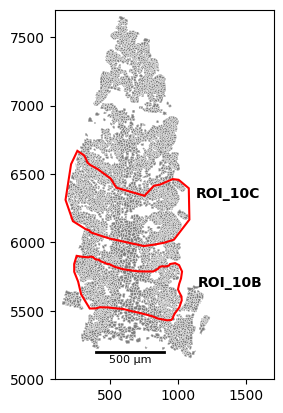

In [83]:
plot_rotated_segmentation_and_roi(
    adata=adata_VGN1a6,
    segmentation_path="cell_segmentation/VGN1a_region6_output/cellpose2_micron_space_VGN1a6.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_7_ROI_geometry.csv',
    rotation_angle=-17,
    xlim=(100, 1700),
    ylim=(5000, 7700),
    scale_bar_length=500,
    scale_bar_position=(400, 5200),
    label_offset=(500,0)
)


In [84]:
roi_cell_map = get_cells_in_rois(
    adata=adata_VGN1a6,
    segmentation_path="cell_segmentation/VGN1a_region6_output/cellpose2_micron_space_VGN1a6.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_7_ROI_geometry.csv',
)


Total unique cells across all ROIs: 2386
ROI_10B: 984 unique intersecting cells
ROI_10C: 1402 unique intersecting cells


In [86]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1a6,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_10B',
    roi_name='ROI_10B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_10B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_10B,0.430226,5.002046,18.538479,7.229326,11.286833,22.157852,8.933517,110.495827,48.464756,...,47.566578,6.702778,2.612266,242.924973,484.202637,250.381592,99.921677,396.877991,490.762787,903.235352


In [87]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1a6,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_10C',
    roi_name='ROI_10C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_10C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_10C,157.752609,118.091415,67.168976,8.857663,178.664047,62.990894,110.721291,124.664467,405.580292,...,78.16777,4.077892,10.760998,204.399689,977.690552,229.578735,168.306625,604.512939,654.210205,655.22644


## POL Terminal Spikelet in silico dissection 

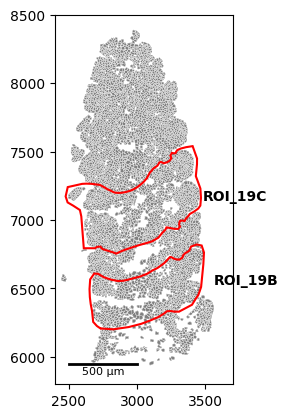

In [89]:
plot_rotated_segmentation_and_roi(
    adata = adata_VGN1a4,
    segmentation_path="cell_segmentation/VGN1a_region4_output/cellpose2_micron_space_VGN1a4.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_14_ROI_geometry.csv',
    rotation_angle=-17,
    xlim=(2400, 3700),
    ylim=(5800, 8500),
    scale_bar_length=500,
    scale_bar_position=(2500, 5950),
    label_offset=(500,0)
)


In [90]:
roi_cell_map = get_cells_in_rois(
    adata = adata_VGN1a4,
    segmentation_path="cell_segmentation/VGN1a_region4_output/cellpose2_micron_space_VGN1a4.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image_14_ROI_geometry.csv',
)


Total unique cells across all ROIs: 2430
ROI_19B: 904 unique intersecting cells
ROI_19C: 1526 unique intersecting cells


In [92]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1a4,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_19B',
    roi_name='ROI_19B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_19B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_19B,5.914087,6.782972,25.24188,5.784263,20.321083,48.637386,17.696211,84.25592,62.572021,...,57.039032,5.436359,6.054667,200.232422,928.727661,304.026855,223.249344,496.951385,557.510193,909.049622


In [93]:
roi_df = export_roi_normalised_counts(
    adata=adata_VGN1a4,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_19C',
    roi_name='ROI_19C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_19C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_19C,389.394989,455.981476,145.256302,8.34431,439.603394,96.671677,256.655701,112.087997,1024.058472,...,115.997742,9.994211,15.530067,290.785553,1635.468506,435.431641,381.22226,787.16449,993.464478,924.78302


## WT Carpel Extension Round  in silico dissection 

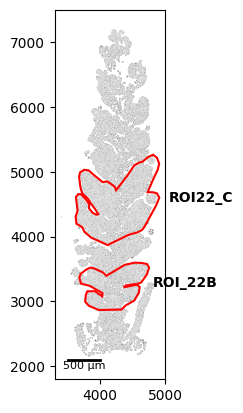

In [95]:
plot_rotated_segmentation_and_roi(
    adata = adata_VGN1c2,
    segmentation_path="cell_segmentation/VGN1c_region2_output/cellpose2_micron_space_VGN1c2.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image17_ROI_geometry.csv',
    rotation_angle=-124,
    xlim=(3300, 5000),
    ylim=(1800, 7500),
    scale_bar_length=500,
    scale_bar_position=(3500, 2100),
    label_offset=(700,0)
)


In [96]:
roi_cell_map = get_cells_in_rois(
    adata = adata_VGN1c2,
    segmentation_path="cell_segmentation/VGN1c_region2_output/cellpose2_micron_space_VGN1c2.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image17_ROI_geometry.csv',
)


Total unique cells across all ROIs: 6763
ROI_22B: 2123 unique intersecting cells
ROI22_C: 4640 unique intersecting cells


In [97]:
roi_df = export_roi_normalised_counts(
    adata = adata_VGN1c2,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI_22B',
    roi_name='ROI_22B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_22B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_22B,50.210201,46.087543,77.074837,20.314163,65.65432,110.075981,85.347191,199.223267,40.721596,...,232.082474,25.492222,18.982935,478.595673,2515.7854,605.132874,669.777527,985.242004,1523.360229,1766.085327


In [99]:
roi_df = export_roi_normalised_counts(
    adata = adata_VGN1c2,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI22_C',
    roi_name='ROI_22C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_22C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_22C,2141.637939,2077.131836,1132.961548,79.538353,2287.585693,439.697174,1153.795532,395.381134,2347.868896,...,319.416443,57.86507,42.770897,1511.830078,6576.027344,1273.396484,1633.341797,2340.558838,3483.459229,3273.685303


## POL Carpel Extension Round  in silico dissection 

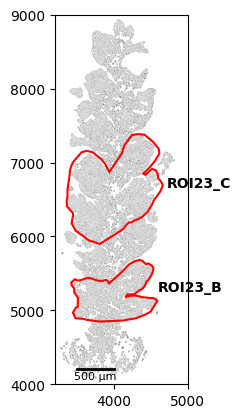

In [101]:
plot_rotated_segmentation_and_roi(
    adata = adata_VGN1c3,
    segmentation_path="cell_segmentation/VGN1c_region3_output/cellpose2_micron_space_VGN1c3.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image18_ROI_geometry.csv',
    rotation_angle=-124,
    xlim=(3200, 5000),
    ylim=(4000, 9000),
    scale_bar_length=500,
    scale_bar_position=(3500, 4200),
    label_offset=(700,0)
)


In [102]:
roi_cell_map = get_cells_in_rois(
    adata = adata_VGN1c3,
    segmentation_path="cell_segmentation/VGN1c_region3_output/cellpose2_micron_space_VGN1c3.parquet",
    roi_csv_path='insilico_dissections/ROI_geometryfiles/Image18_ROI_geometry.csv',
)


Total unique cells across all ROIs: 7022
ROI23_B: 2342 unique intersecting cells
ROI23_C: 4680 unique intersecting cells


In [103]:
roi_df = export_roi_normalised_counts(
    adata = adata_VGN1c3,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI23_B',
    roi_name='ROI_23B',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_23B_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_23B,254.271713,220.106064,157.53299,32.122944,222.926117,124.343468,133.896149,152.048569,149.029831,...,133.362717,18.492874,25.414936,365.639099,2659.247559,461.231934,402.946777,921.246765,1484.83313,1352.852539


In [104]:
roi_df = export_roi_normalised_counts(
    adata = adata_VGN1c3,
    roi_cell_map=roi_cell_map,
    original_roi_key='ROI23_C',
    roi_name='ROI_23C',
    folder_path='insilico_dissections/ROI_normalised_counts_CSVs'
)
roi_df

Saved normalized counts to C:/Users/longk/OneDrive - Norwich Bioscience Institutes/PhD/Experimental Details/longk_exp9_VizGen/publication/insilico_dissections/ROI_normalised_counts_CSVs\ROI_23C_normcounts.csv


,EntityID,TraesCS7D02G261600,TraesCS5A02G286800,TraesCS3A02G406500,TraesCS4D02G301100,TraesCS1A02G264300,TraesCS4D02G243700,TraesCS1D02G127700,TraesCS7D02G388600,TraesCS6A02G259000,...,TraesCS4A02G434900,TraesCS5A02G405900,TraesCS5B02G560300,TraesCS6A02G373500,TraesCS2B02G260800,TraesCS1B02G283900,TraesCS6A02G213700,TraesCS2A02G323500,TraesCS2B02G274200,TraesCS1B02G042200
0,ROI_23C,1647.561768,1439.806885,765.753113,59.089207,1607.905762,381.5271,841.009644,297.523987,1895.192627,...,218.06369,42.169559,40.374496,1015.789612,5860.655273,928.362122,1148.598633,1843.125488,2942.775879,3092.790039


# Now I want to correlate these counts within each ROI to the TPM from our RNA-seq datset

First I will read in the counts and a metadata file to match up each stage/section combination 

### reading in TPM from microdissection RNAseq dataset

In [107]:
# Set working directory and read the CSV
paragon_tpms = pd.read_csv('RNAseq/file_records/P8_P5_Arr_tpms_means_2022_data.csv', index_col =None)
paragon_tpms = paragon_tpms.drop(columns='Unnamed: 0')

# Drop columns containing "PI.191837" or "Classic"
paragon_tpms = paragon_tpms.loc[:, ~paragon_tpms.columns.str.contains("PI.191837|Classic")]

# Rename columns
paragon_tpms = paragon_tpms.rename(columns={
    "EDD_P5-NIL (pol)_basal": "P5_EDR_B",
    "EDD_P5-NIL (pol)_central": "P5_EDR_C",
    "EDD_P8-NIL (par)_basal": "P8_EDR_B",
    "EDD_P8-NIL (par)_central": "P8_EDR_C",
    "LDD_P5-NIL (pol)_basal": "P5_LDR_B",
    "LDD_P5-NIL (pol)_central": "P5_LDR_C",
    "LDD_P8-NIL (par)_basal": "P8_LDR_B",
    "LDD_P8-NIL (par)_central": "P8_LDR_C",
    "LPD_P5-NIL (pol)_basal": "P5_LP_B",
    "LPD_P5-NIL (pol)_central": "P5_LP_C",
    "LPD_P8-NIL (par)_basal": "P8_LP_B",
    "LPD_P8-NIL (par)_central": "P8_LP_C",
    "LTD_P5-NIL (pol)_basal": "P5_CER_B",
    "LTD_P5-NIL (pol)_central": "P5_CER_C",
    "LTD_P8-NIL (par)_basal": "P8_CER_B",
    "LTD_P8-NIL (par)_central": "P8_CER_C",
    "TSD_P5-NIL (pol)_basal": "P5_TS_B",
    "TSD_P5-NIL (pol)_central": "P5_TS_C",
    "TSD_P8-NIL (par)_basal": "P8_TS_B",
    "TSD_P8-NIL (par)_central": "P8_TS_C"
})


paragon_tpms.rename(columns={'gene_id': 'gene'}, inplace=True)
paragon_tpms

# Set custom column order
new_columns = ["gene", "P5_EDR_B", "P5_EDR_C", "P8_EDR_B", "P8_EDR_C", 
               "P5_LDR_B", "P5_LDR_C", "P8_LDR_B", "P8_LDR_C",
               "P5_LP_B",  "P5_LP_C",  "P8_LP_B",  "P8_LP_C",
               "P5_CER_B",  "P5_CER_C",  "P8_CER_B",  "P8_CER_C",
               "P5_TS_B",  "P5_TS_C",  "P8_TS_B",  "P8_TS_C"]

# If not already in this order, reorder (assuming 'gene' is the first column)
paragon_tpms = paragon_tpms[new_columns]

# Show shape and head of the dataframe
print(paragon_tpms.shape)

(269428, 21)


### reading in genes included in panel 

In [112]:
import pandas as pd

# Load the subset gene list
subset200_path = "insilico_dissections/subset_200_spikegenes_list.txt"
subset200 = pd.read_csv(subset200_path, header=None, names=["gene"])

# Load the VizGen panel
panel_path = "insilico_dissections/VizGen_panel.tsv"
panel = pd.read_csv(panel_path, sep="\t")

# Print gene counts
print("Number of genes in initial panel:", panel.shape[0])

# Subset panel to the 200 genes
panel_subset = panel[panel['gene'].isin(subset200['gene'])]

print("Number of genes in subsetted panel:", panel_subset.shape)


# Merge with paragon_tpms (you'll need to have run the previous block for this to work)
paragon_panel = pd.merge(panel_subset, paragon_tpms, on="gene")

# Replace "grain" with "spike" in target_tissue column
paragon_panel['target_tissue'] = paragon_panel['target_tissue'].replace("grain", "spike")


Number of genes in initial panel: 300
Number of genes in subsetted panel: (200, 6)


### reading in metadata 

In [108]:
# Load the Excel metadata file
metadata_path = "insilico_dissections/metadata_insilico_dissections.xlsx"
metadata = pd.read_excel(metadata_path)

# Select only the relevant columns
metadata = metadata[["ROI_name", "Genotype", "Stage", "Section", "ROI_File", "RNAseq_Sample_Pair"]]


metadata.rename(columns={'ROI_name': 'ROI'}, inplace=True)

metadata

,ROI,Genotype,Stage,Section,ROI_File,RNAseq_Sample_Pair
0,ROI_1B,P8,LDR,Basal,ROI_normalised_counts_CSVs/ROI_1B_normcounts.csv,P8_LDR_B
1,ROI_1C,P8,LDR,Central,ROI_normalised_counts_CSVs/ROI_1C_normcounts.csv,P8_LDR_C
2,ROI_13B,P5,LDR,Basal,ROI_normalised_counts_CSVs/ROI_13B_normcounts.csv,P5_LDR_B
3,ROI_13C,P5,LDR,Central,ROI_normalised_counts_CSVs/ROI_13C_normcounts.csv,P5_LDR_C
4,ROI_5B,P8,LP,Basal,ROI_normalised_counts_CSVs/ROI_5B_normcounts.csv,P8_LP_B
5,ROI_5C,P8,LP,Central,ROI_normalised_counts_CSVs/ROI_5C_normcounts.csv,P8_LP_C
6,ROI_17B,P5,LP,Basal,ROI_normalised_counts_CSVs/ROI_17B_normcounts.csv,P5_LP_B
7,ROI_17C,P5,LP,Central,ROI_normalised_counts_CSVs/ROI_17C_normcounts.csv,P5_LP_C
8,ROI_10B,P8,TS,Basal,ROI_normalised_counts_CSVs/ROI_10B_normcounts.csv,P8_TS_B
9,ROI_10C,P8,TS,Central,ROI_normalised_counts_CSVs/ROI_10C_normcounts.csv,P8_TS_C


## make the correlations between the in silico normalised counts and the semi spatial TPM

I used spearman's because I want to measure the strength and direction of the monotonic relationship between my two variables (as a value of one variable increases, so does the other variable)

I am using this because it doesn't assume linearity between two variables 


In [113]:
# Convert to lists
roi_files = metadata['ROI_File'].tolist()
correlation_RNAseq = metadata['RNAseq_Sample_Pair'].tolist()

# Function to calculate correlations
def calculate_correlations(roi_file, paragon_matrix, correlation_column):
    try:
        # Load and preprocess the ROI file
        roi_data = pd.read_csv(roi_file, header=None).T
        roi_data.columns = ["gene", "count"]
        roi_data = roi_data.iloc[1:]  # Drop first row (assumes it's metadata or labels)
        roi_data["count"] = pd.to_numeric(roi_data["count"], errors="coerce")

        # Merge with paragon matrix on 'gene'
        merged = pd.merge(paragon_matrix, roi_data, on="gene")

        # Check if the correlation column exists
        if correlation_column not in merged.columns:
            raise ValueError(f"Column {correlation_column} not found in merged data.")

        # Drop missing values
        x = pd.to_numeric(merged[correlation_column], errors='coerce')
        y = pd.to_numeric(merged["count"], errors='coerce')
        mask = x.notna() & y.notna()
        x, y = x[mask], y[mask]

        # Compute correlations
        spearman_r, spearman_p = spearmanr(x, y)

        # Assemble result
        result = pd.DataFrame([{
            "ROI": roi_file,
            "correlation_RNAseq": correlation_column,
            "Spearman_Rho": round(spearman_r, 3),
            "Spearman_P": format(spearman_p, ".3e")
        }])

        return result

    except Exception as e:
        print(f"Error processing {roi_file}: {e}")
        return pd.DataFrame()

# Initialize results
total_results = pd.DataFrame()

# Run through all ROI files and correlation targets
for roi_file, correlation_col in zip(roi_files, correlation_RNAseq):
    full_path = os.path.join("insilico_dissections", roi_file)
    result_df = calculate_correlations(full_path, paragon_panel, correlation_col)
    total_results = pd.concat([total_results, result_df], ignore_index=True)

# Final results

print(total_results.shape)
total_results

(16, 4)


,ROI,correlation_RNAseq,Spearman_Rho,Spearman_P
0,insilico_dissections\ROI_normalised_counts_CSV...,P8_LDR_B,0.727,3.135e-34
1,insilico_dissections\ROI_normalised_counts_CSV...,P8_LDR_C,0.686,3.545e-29
2,insilico_dissections\ROI_normalised_counts_CSV...,P5_LDR_B,0.641,1.713e-24
3,insilico_dissections\ROI_normalised_counts_CSV...,P5_LDR_C,0.641,1.710e-24
4,insilico_dissections\ROI_normalised_counts_CSV...,P8_LP_B,0.651,1.796e-25
5,insilico_dissections\ROI_normalised_counts_CSV...,P8_LP_C,0.648,3.522e-25
6,insilico_dissections\ROI_normalised_counts_CSV...,P5_LP_B,0.628,2.298e-23
7,insilico_dissections\ROI_normalised_counts_CSV...,P5_LP_C,0.615,3.461e-22
8,insilico_dissections\ROI_normalised_counts_CSV...,P8_TS_B,0.677,3.751e-28
9,insilico_dissections\ROI_normalised_counts_CSV...,P8_TS_C,0.657,3.980e-26


### saving calculated correlations to file 

In [ ]:
results2 = total_results.copy()
results2 = results2.drop(columns = ['ROI'])
results2.rename(columns={'correlation_RNAseq': 'RNAseq_Sample_Pair'}, inplace=True)

metadata2 = metadata.copy()
metadata2 = metadata2.drop(columns = ['ROI_File'])

merged_correlations = pd.merge(results2, metadata2, how = 'left', on = 'RNAseq_Sample_Pair')
new_columns = ["Genotype", "Stage", "Section", "ROI", "RNAseq_Sample_Pair", 
               "Spearman_Rho", "Spearman_P"]
merged_correlations = merged_correlations[new_columns]
merged_correlations.to_csv('insilico_dissections/SpearmanCorrelations_insilico_dissections.csv', header=True)